# Full Version

Best sensitivity: 7
Best ATR period: 47
Best Sharpe: 1.848


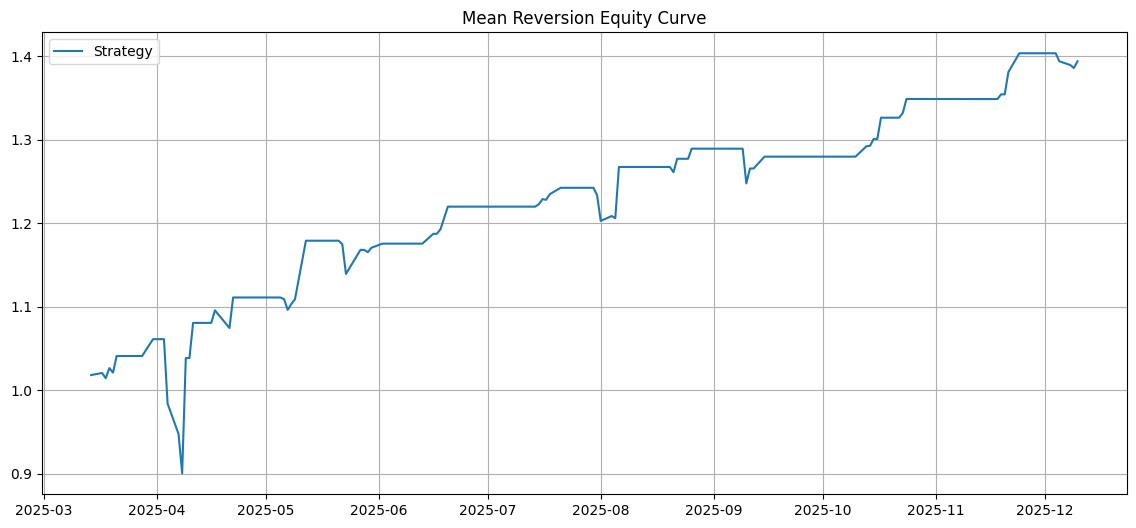

Sharpe: 1.848
Total Return: 0.394


In [7]:
# ==============================
# MEAN REVERSION STRATEGY
# NO LOOK-AHEAD BIAS
# FULL WORKING SCRIPT (FIXED)
# ==============================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import warnings
warnings.filterwarnings("ignore")


# ======================================================
# CORE STRATEGY FUNCTION (FOR OPTIMIZATION)
# ======================================================
def mean_reversion(stock, start, end, sensitivity, period):

    # ----------- DOWNLOAD DATA -----------
    df_h = yf.download(
        stock, interval="1h", start=start, end=end,
        auto_adjust=True, progress=False
    )

    df_d = yf.download(
        stock, interval="1d", start=start, end=end,
        auto_adjust=True, progress=False
    )

    # normalize columns
    if isinstance(df_h.columns, pd.MultiIndex):
        df_h.columns = df_h.columns.get_level_values(0)
    if isinstance(df_d.columns, pd.MultiIndex):
        df_d.columns = df_d.columns.get_level_values(0)

    df_h = df_h[["Close"]].dropna()
    df_d = df_d[["Close"]].dropna()

    # remove timezone
    df_h.index = df_h.index.tz_localize(None)
    df_d.index = df_d.index.tz_localize(None)

    # ----------- DAILY FEATURES FROM HOURLY (NO LOOK-AHEAD) -----------
    daily_high = df_h["Close"].resample("1D").max()
    daily_low  = df_h["Close"].resample("1D").min()

    df_d["Daily_Diff"] = daily_high - daily_low
    df_d["Daily_Max"] = daily_high

    # ATR and rolling max
    df_d["ATR"] = df_d["Daily_Diff"].rolling(period).mean()
    df_d["Roll_Max"] = df_d["Daily_Max"].rolling(sensitivity).max()

    # shift EVERYTHING used for decisions
    feature_cols = ["Daily_Diff", "Daily_Max", "ATR", "Roll_Max"]
    df_d[feature_cols] = df_d[feature_cols].shift(1)

    df_d.dropna(inplace=True)

    # ----------- SIGNALS -----------
    df_d["Entry_Band"] = df_d["Roll_Max"] - 2.5 * df_d["ATR"]

    enter = df_d["Close"] < df_d["Entry_Band"]
    exit_ = df_d["Close"] > df_d["Daily_Max"]

    # ----------- POSITION STATE MACHINE -----------
    pos = 0
    positions = []

    for i in range(len(df_d)):
        if pos == 0 and enter.iloc[i]:
            pos = 1
        elif pos == 1 and exit_.iloc[i]:
            pos = 0
        positions.append(pos)

    df_d["Position"] = pd.Series(positions, index=df_d.index).shift(1).fillna(0)

    # ----------- RETURNS -----------
    ret = df_d["Close"].pct_change()
    strat = ret * df_d["Position"]

    strat.dropna(inplace=True)

    if strat.std() == 0:
        return -10

    sharpe = np.sqrt(252) * strat.mean() / strat.std()
    return sharpe, df_h


# ======================================================
# PARAMETER SEARCH
# ======================================================
max_sr = -10
final_s = None
final_prd = None
final_df=pd.DataFrame()
for s in range(5, 60):
    for prd in range(4, 50):
        sr, df = mean_reversion("AAPL", "2025-01-01", "2025-12-11", s, prd)
        if sr > max_sr:
            max_sr = sr
            final_s = s
            final_prd = prd
            final_df=df

print("Best sensitivity:", final_s)
print("Best ATR period:", final_prd)
print("Best Sharpe:", round(max_sr, 3))


# ======================================================
# VISUALIZATION
# ======================================================
def mean_reversion_visual(stock, start, end, sensitivity, period):

    df_h = yf.download(
        stock, interval="1h", start=start, end=end,
        auto_adjust=True, progress=False
    )

    df_d = yf.download(
        stock, interval="1d", start=start, end=end,
        auto_adjust=True, progress=False
    )

    if isinstance(df_h.columns, pd.MultiIndex):
        df_h.columns = df_h.columns.get_level_values(0)
    if isinstance(df_d.columns, pd.MultiIndex):
        df_d.columns = df_d.columns.get_level_values(0)

    df_h = df_h[["Close"]].dropna()
    df_d = df_d[["Close"]].dropna()

    df_h.index = df_h.index.tz_localize(None)
    df_d.index = df_d.index.tz_localize(None)

    daily_high = df_h["Close"].resample("1D").max()
    daily_low  = df_h["Close"].resample("1D").min()

    df_d["Daily_Diff"] = daily_high - daily_low
    df_d["Daily_Max"] = daily_high
    df_d["ATR"] = df_d["Daily_Diff"].rolling(period).mean()
    df_d["Roll_Max"] = df_d["Daily_Max"].rolling(sensitivity).max()

    feature_cols = ["Daily_Diff", "Daily_Max", "ATR", "Roll_Max"]
    df_d[feature_cols] = df_d[feature_cols].shift(1)

    df_d.dropna(inplace=True)

    df_d["Entry_Band"] = df_d["Roll_Max"] - 2.5 * df_d["ATR"]

    enter = df_d["Close"] < df_d["Entry_Band"]
    exit_ = df_d["Close"] > df_d["Daily_Max"]

    pos = 0
    positions = []

    for i in range(len(df_d)):
        if pos == 0 and enter.iloc[i]:
            pos = 1
        elif pos == 1 and exit_.iloc[i]:
            pos = 0
        positions.append(pos)

    df_d["Position"] = pd.Series(positions, index=df_d.index).shift(1).fillna(0)

    ret = df_d["Close"].pct_change()
    strat = ret * df_d["Position"]
    strat.dropna(inplace=True)

    sharpe = np.sqrt(252) * strat.mean() / strat.std()

    equity = (1 + strat).cumprod()

    plt.figure(figsize=(14,6))
    plt.plot(equity, label="Strategy")
    plt.title("Mean Reversion Equity Curve")
    plt.grid()
    plt.legend()
    plt.show()

    print("Sharpe:", round(sharpe, 3))
    print("Total Return:", round(equity.iloc[-1] - 1, 3))


# ======================================================
# RUN FINAL STRATEGY
# ======================================================
mean_reversion_visual(
    "AAPL", "2025-01-01", "2025-12-11",
    final_s, final_prd
)


# Adjusted Version 2

Best sensitivity: 5
Best ATR period: 4
Best Sharpe: 0.677


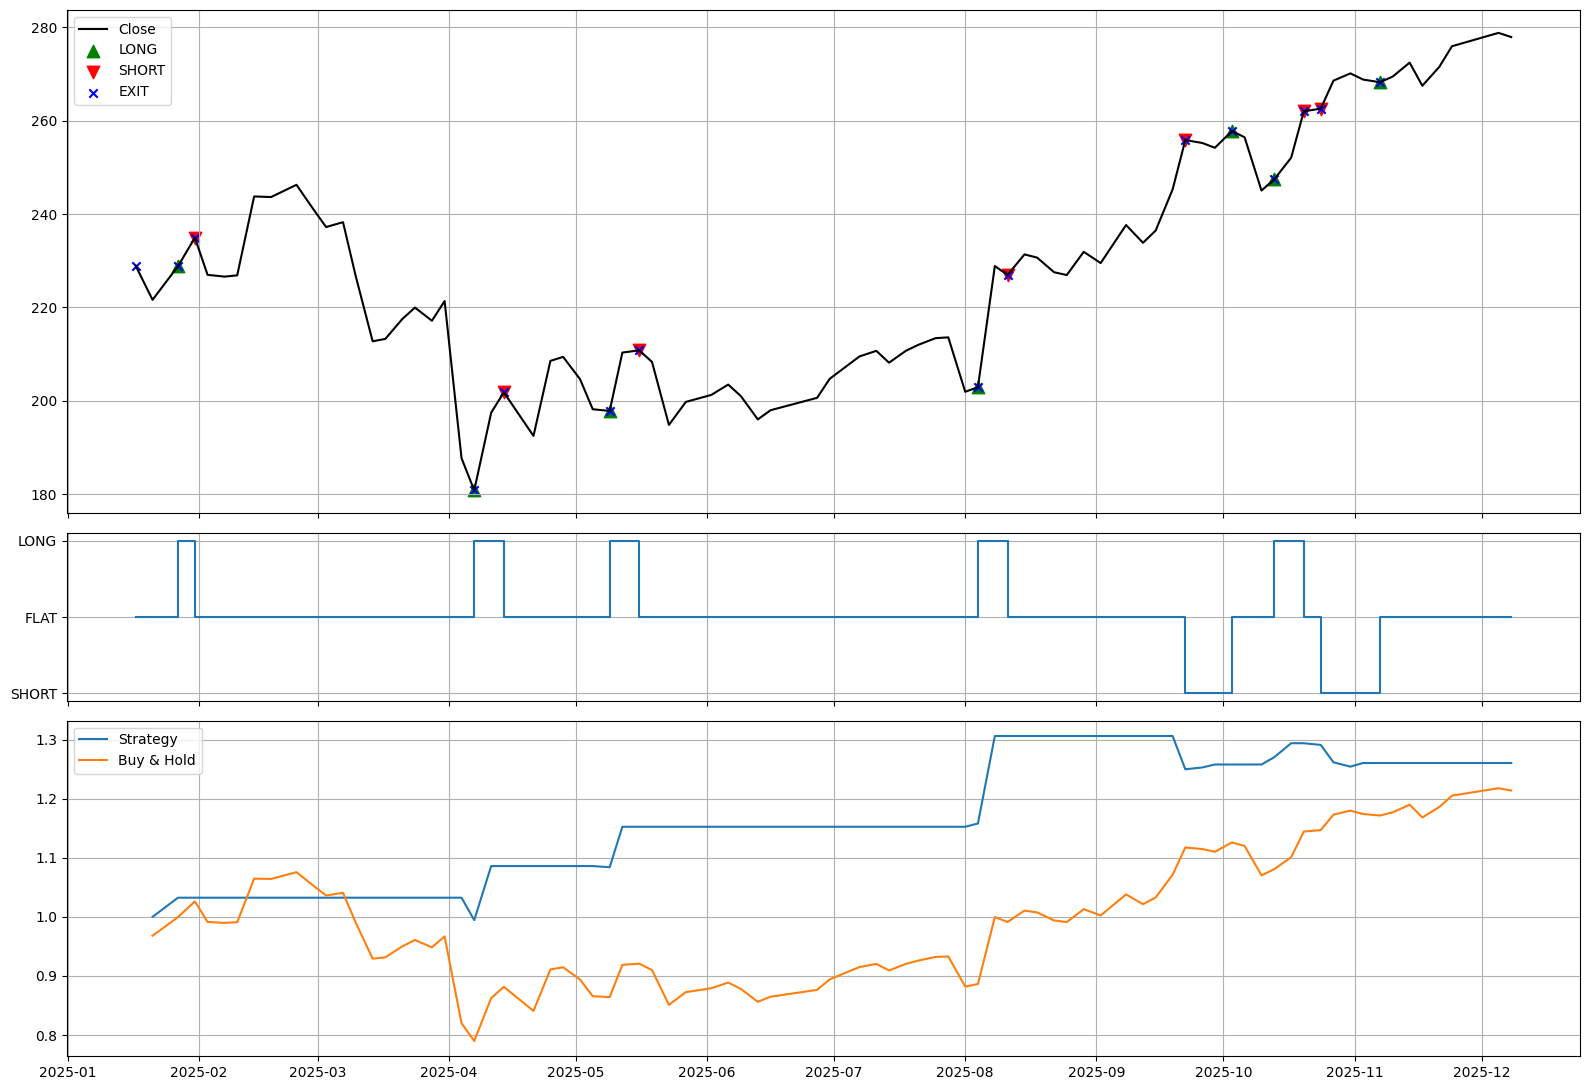

Sharpe: 2.346
Total Return: 0.26


In [11]:
# ==============================
# MEAN REVERSION STRATEGY
# LONG + SHORT
# NO LOOK-AHEAD BIAS
# FULL SCRIPT
# ==============================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import warnings
warnings.filterwarnings("ignore")

# ======================================================
# CORE STRATEGY FUNCTION (FOR OPTIMIZATION)
# ======================================================
def mean_reversion(stock, start, end, sensitivity, period, k=2.5):

    # ----------- DOWNLOAD DATA -----------
    df_h = yf.download(
        stock, interval="1h", start=start, end=end,
        auto_adjust=True, progress=False
    )

    df_d = yf.download(
        stock, interval="1d", start=start, end=end,
        auto_adjust=True, progress=False
    )

    if isinstance(df_h.columns, pd.MultiIndex):
        df_h.columns = df_h.columns.get_level_values(0)
    if isinstance(df_d.columns, pd.MultiIndex):
        df_d.columns = df_d.columns.get_level_values(0)

    df_h = df_h[["Close"]].dropna()
    df_d = df_d[["Close"]].dropna()

    df_h.index = df_h.index.tz_localize(None)
    df_d.index = df_d.index.tz_localize(None)

    # ----------- DAILY FEATURES (NO LOOK-AHEAD) -----------
    daily_high = df_h["Close"].resample("1D").max()
    daily_low  = df_h["Close"].resample("1D").min()

    df_d["Daily_Max"] = daily_high
    df_d["Daily_Min"] = daily_low
    df_d["Daily_Diff"] = daily_high - daily_low

    df_d["ATR"] = df_d["Daily_Diff"].rolling(period).mean()
    df_d["Roll_Max"] = df_d["Daily_Max"].rolling(sensitivity).max()
    df_d["Roll_Min"] = df_d["Daily_Min"].rolling(sensitivity).min()

    # shift all features
    feat = ["ATR", "Roll_Max", "Roll_Min", "Daily_Max", "Daily_Min"]
    df_d[feat] = df_d[feat].shift(1)
    df_d.dropna(inplace=True)

    # ----------- BANDS -----------
    df_d["Upper_Band"] = df_d["Roll_Max"] + k * df_d["ATR"]
    df_d["Lower_Band"] = df_d["Roll_Min"] - k * df_d["ATR"]

    # ----------- SIGNALS -----------
    long_entry  = df_d["Close"] < df_d["Lower_Band"]
    short_entry = df_d["Close"] > df_d["Upper_Band"]

    long_exit   = df_d["Close"] > df_d["Daily_Max"]
    short_exit  = df_d["Close"] < df_d["Daily_Min"]

    # ----------- POSITION STATE MACHINE -----------
    pos = 0
    positions = []

    for i in range(len(df_d)):
        if pos == 0:
            if long_entry.iloc[i]:
                pos = 100
            elif short_entry.iloc[i]:
                pos = -100

        elif pos == 100 and long_exit.iloc[i]:
            pos = 0

        elif pos == -100 and short_exit.iloc[i]:
            pos = 0

        positions.append(pos)

    df_d["Position"] = (
        pd.Series(positions, index=df_d.index)
        .shift(1)
        .fillna(0)
    )

    # ----------- RETURNS -----------
    ret = df_d["Close"].pct_change()
    strat = ret * df_d["Position"] / 100
    strat.dropna(inplace=True)

    if strat.std() == 0:
        return -10

    sharpe = np.sqrt(252) * strat.mean() / strat.std()
    return sharpe


# ======================================================
# PARAMETER SEARCH
# ======================================================
max_sr = -10
final_s = None
final_prd = None

for s in range(5, 60):
    for prd in range(4, 40):
        sr = mean_reversion(
            "AAPL",
            "2025-01-01",
            "2025-12-11",
            s,
            prd
        )
        if sr > max_sr:
            max_sr = sr
            final_s = s
            final_prd = prd

print("Best sensitivity:", final_s)
print("Best ATR period:", final_prd)
print("Best Sharpe:", round(max_sr, 3))


# ======================================================
# FINAL VISUALIZATION
# ======================================================
def mean_reversion_visual(stock, start, end, sensitivity, period, k=2.5):

    df_h = yf.download(
        stock, interval="1h", start=start, end=end,
        auto_adjust=True, progress=False
    )

    df_d = yf.download(
        stock, interval="1d", start=start, end=end,
        auto_adjust=True, progress=False
    )

    if isinstance(df_h.columns, pd.MultiIndex):
        df_h.columns = df_h.columns.get_level_values(0)
    if isinstance(df_d.columns, pd.MultiIndex):
        df_d.columns = df_d.columns.get_level_values(0)

    df_h = df_h[["Close"]].dropna()
    df_d = df_d[["Close"]].dropna()

    df_h.index = df_h.index.tz_localize(None)
    df_d.index = df_d.index.tz_localize(None)

    daily_high = df_h["Close"].resample("1D").max()
    daily_low  = df_h["Close"].resample("1D").min()

    df_d["Daily_Max"] = daily_high
    df_d["Daily_Min"] = daily_low
    df_d["ATR"] = (daily_high - daily_low).rolling(period).mean()
    df_d["Roll_Max"] = df_d["Daily_Max"].rolling(sensitivity).max()
    df_d["Roll_Min"] = df_d["Daily_Min"].rolling(sensitivity).min()

    df_d[["ATR","Roll_Max","Roll_Min","Daily_Max","Daily_Min"]] = \
        df_d[["ATR","Roll_Max","Roll_Min","Daily_Max","Daily_Min"]].shift(1)

    df_d.dropna(inplace=True)

    df_d["Upper_Band"] = df_d["Roll_Max"] + k * df_d["ATR"]
    df_d["Lower_Band"] = df_d["Roll_Min"] - k * df_d["ATR"]

    long_entry  = df_d["Close"] < df_d["Lower_Band"]
    short_entry = df_d["Close"] > df_d["Upper_Band"]
    long_exit   = df_d["Close"] > df_d["Daily_Max"]
    short_exit  = df_d["Close"] < df_d["Daily_Min"]

    pos = 0
    positions = []

    for i in range(len(df_d)):
        if pos == 0:
            if long_entry.iloc[i]:
                pos = 100
            elif short_entry.iloc[i]:
                pos = -100
        elif pos == 100 and long_exit.iloc[i]:
            pos = 0
        elif pos == -100 and short_exit.iloc[i]:
            pos = 0
        positions.append(pos)

    df_d["Position"] = (
        pd.Series(positions, index=df_d.index)
        .shift(1)
        .fillna(0)
    )

    ret = df_d["Close"].pct_change()
    strat = ret * df_d["Position"] / 100
    equity = (1 + strat.dropna()).cumprod()
    stock_eq = (1 + ret.dropna()).cumprod()

    # ================= PLOTS =================
    fig, (ax1, ax2, ax3) = plt.subplots(
        3, 1, figsize=(16, 11),
        sharex=True,
        gridspec_kw={"height_ratios": [3, 1, 2]}
    )

    # Price + trades
    ax1.plot(df_d.index, df_d["Close"], label="Close", color="black")
    ax1.scatter(df_d.index[df_d["Position"].diff()==100],
                df_d["Close"][df_d["Position"].diff()==100],
                marker="^", color="green", s=80, label="LONG")
    ax1.scatter(df_d.index[df_d["Position"].diff()==-100],
                df_d["Close"][df_d["Position"].diff()==-100],
                marker="v", color="red", s=80, label="SHORT")
    ax1.scatter(df_d.index[df_d["Position"].diff()!=0],
                df_d["Close"][df_d["Position"].diff()!=0],
                marker="x", color="blue", label="EXIT")
    ax1.legend()
    ax1.grid(True)

    # Position
    ax2.step(df_d.index, df_d["Position"], where="post")
    ax2.set_yticks([-100, 0, 100])
    ax2.set_yticklabels(["SHORT","FLAT","LONG"])
    ax2.grid(True)

    # Equity
    ax3.plot(equity, label="Strategy")
    ax3.plot(stock_eq, label="Buy & Hold")
    ax3.legend()
    ax3.grid(True)

    plt.tight_layout()
    plt.show()

    sharpe = np.sqrt(252) * strat.mean() / strat.std()
    print("Sharpe:", round(sharpe, 3))
    print("Total Return:", round(equity.iloc[-1]-1, 3))


# ======================================================
# RUN FINAL STRATEGY
# ======================================================
mean_reversion_visual(
    "AAPL",
    "2025-01-01",
    "2025-12-11",
    final_s,
    final_prd
)
